In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/validation-iiith/VGG16_val_features/VGG16_val_features/frontal_view/Right Lane Change/f4dbd59d-bdac-4ac8-912a-6226f3f90e8c.npy
/kaggle/input/validation-iiith/VGG16_val_features/VGG16_val_features/frontal_view/Right Lane Change/b5dd18be-4ab5-4735-8c46-33d97d5e2401.npy
/kaggle/input/validation-iiith/VGG16_val_features/VGG16_val_features/frontal_view/Right Lane Change/89d1fdb7-fbe0-476f-8c39-a5bfcb83a4dd.npy
/kaggle/input/validation-iiith/VGG16_val_features/VGG16_val_features/frontal_view/Right Lane Change/5b9462a5-d258-4773-bd35-3e2b62cba7c2.npy
/kaggle/input/validation-iiith/VGG16_val_features/VGG16_val_features/frontal_view/Right Lane Change/abd9b125-26d2-4089-a153-89e2ae502705.npy
/kaggle/input/validation-iiith/VGG16_val_features/VGG16_val_features/frontal_view/Right Lane Change/ad0fb955-e0ae-44ae-8abf-80345b6bb435.npy
/kaggle/input/validation-iiith/VGG16_val_features/VGG16_val_features/frontal_view/Right Lane Change/0843dc51-3c6b-4873-b27d-4008da524fa3.npy
/kaggle/input

task 1 test submission

In [3]:
import numpy as np
import tensorflow as tf
from pathlib import Path
from joblib import Parallel, delayed
import pandas as pd

dataset_path_vgg16 = Path("/kaggle/input/testdataripiiith/R(21)D_test_features/R(2+1)D_test_features/frontal_view")

def load_vgg_file(file_path):
    try:
        data = np.load(file_path, allow_pickle=True)
        return data
    except Exception as e:
        print(f"Error loading {file_path}: {e}")
        return None

def process_folder(folder_path):
    folder_path = Path(folder_path)
    files = list(folder_path.glob('*.npy'))
    
    features = []
    video_names = []
    missing_files = []

    print(f"Processing folder: {folder_path}")

    for file in files:
        print(f"Processing file: {file}")
        feature = load_vgg_file(file)
        
        if feature is None:
            missing_files.append(file.stem)
            continue
        
        
        if feature.ndim == 1:
            feature = feature.reshape(1, -1)
        elif feature.ndim > 2:
            feature = feature.reshape(feature.shape[0], -1)
        
        if feature.shape[0] == 0 or feature.shape[1] == 0:
            missing_files.append(file.stem)
            continue
        
        features.append(feature)
        video_names.append(file.stem)
    
    if features:
        return np.vstack(features), video_names, missing_files
    return None, [], missing_files

def load_dataset_vgg16(dataset_path):
    all_features = []
    video_names_all = []
    missing_files_all = []

    print(f"Loading dataset for VGG16")
    results = Parallel(n_jobs=-1)(delayed(process_folder)(dataset_path) for _ in [dataset_path])
    
    backbone_features = [result[0] for result in results if result[0] is not None]
    video_names = [result[1] for result in results if result[1] is not None]
    missing_files = [result[2] for result in results if result[2] is not None]

    if backbone_features:
        backbone_features = [f for f in backbone_features if f.size > 0]
        if backbone_features:
            features = np.vstack(backbone_features)
            video_names_all.extend([name for sublist in video_names for name in sublist])
            missing_files_all.extend([name for sublist in missing_files for name in sublist])
            all_features.append(features)
        else:
            print(f"No valid features found for VGG16")
    else:
        print(f"No features found for VGG16")

    if all_features:
        X_combined = np.vstack(all_features)
    else:
        raise ValueError("No features available to combine")
    
    return X_combined, video_names_all, missing_files_all

# Load the VGG16 dataset
X_vgg16, video_names_vgg16, missing_vgg16 = load_dataset_vgg16(dataset_path_vgg16)

# Check if feature arrays are empty
if X_vgg16.size == 0:
    raise ValueError("VGG16 features are empty")

# Normalize features
X_vgg16 = X_vgg16.astype(np.float32) / 255

print(f"VGG16 video count: {len(video_names_vgg16)}")
print(f"Missing VGG16 videos: {len(missing_vgg16)}")
print(f"Missing VGG16 video names: {missing_vgg16}")

# Reshape the data to match the model's expected input shape
X_vgg16_reshaped = X_vgg16.reshape(-1, 16, 16, 2)

model_path = '/kaggle/input/testdataripiiith/best_modelnewtask1.keras'
model = tf.keras.models.load_model(model_path)

# Predict using the model
def predict_and_average(X, video_names):
    predictions = model.predict(X)
    binary_predictions = np.zeros_like(predictions)
    max_indices = np.argmax(predictions, axis=1)
    for i, idx in enumerate(max_indices):
        binary_predictions[i, idx] = 1

    predictions_dict = dict(zip(video_names, binary_predictions))

    averaged_predictions = {}
    for video_name, pred in predictions_dict.items():
        if video_name in averaged_predictions:
            averaged_predictions[video_name].append(pred)
        else:
            averaged_predictions[video_name] = [pred]
    
    # Compute average predictions
    final_predictions = {}
    for video_name, preds in averaged_predictions.items():
        avg_pred = np.mean(np.array(preds), axis=0)
        final_predictions[video_name] = avg_pred
    
    return final_predictions

# Predict and average results for VGG16
averaged_predictions_vgg16 = predict_and_average(X_vgg16_reshaped, video_names_vgg16)

print(f"VGG16 prediction count: {len(averaged_predictions_vgg16)}")

df_vgg16 = pd.DataFrame(averaged_predictions_vgg16.values(), columns=[f'Class_{i}' for i in range(averaged_predictions_vgg16[list(averaged_predictions_vgg16.keys())[0]].size)], index=averaged_predictions_vgg16.keys())
df_vgg16.insert(0, 'video_name', df_vgg16.index)
df_vgg16.insert(1, 'backbone', 'VGG16')

# Save the final predictions to CSV
df_vgg16.to_csv('/kaggle/working/final_predictions_vgg16.csv', index=False)

print("Final VGG16 predictions saved to final_predictions_vgg16.csv")


Loading dataset for VGG16
Processing folder: /kaggle/input/testdataripiiith/R(21)D_test_features/R(2+1)D_test_features/frontal_view
Processing file: /kaggle/input/testdataripiiith/R(21)D_test_features/R(2+1)D_test_features/frontal_view/241c8f63-34f8-4fa8-8ac3-e1c2ba75fbb4.npy
Processing file: /kaggle/input/testdataripiiith/R(21)D_test_features/R(2+1)D_test_features/frontal_view/e2a1add5-4438-4ce9-a6c3-24731f58e99d.npy
Processing file: /kaggle/input/testdataripiiith/R(21)D_test_features/R(2+1)D_test_features/frontal_view/5bd68e52-2630-4bde-99a6-99bede4b6de0.npy
Processing file: /kaggle/input/testdataripiiith/R(21)D_test_features/R(2+1)D_test_features/frontal_view/b629c6f9-8d83-43b5-8845-1447c850b90b.npy
Processing file: /kaggle/input/testdataripiiith/R(21)D_test_features/R(2+1)D_test_features/frontal_view/42a362bd-7c23-4380-a042-a992f7fb75c9.npy
Processing file: /kaggle/input/testdataripiiith/R(21)D_test_features/R(2+1)D_test_features/frontal_view/d046d8b5-670e-4a36-9e23-257316c8719e.np

task 2 test submission

In [1]:
import numpy as np
import tensorflow as tf
from pathlib import Path
from joblib import Parallel, delayed
import pandas as pd

# Define paths to the VGG16 validation datasets
dataset_paths_vgg16 = [
    Path("/kaggle/input/testdataripiiith/R(21)D_test_features/R(2+1)D_test_features/frontal_view"),
    Path("/kaggle/input/testdataripiiith/R(21)D_test_features/R(2+1)D_test_features/left_view"),
    Path("/kaggle/input/testdataripiiith/R(21)D_test_features/R(2+1)D_test_features/right_view")
]

def load_vgg_file(file_path):
    try:
        data = np.load(file_path, allow_pickle=True)
        return data
    except Exception as e:
        print(f"Error loading {file_path}: {e}")
        return None

def process_folder(folder_path):
    folder_path = Path(folder_path)
    files = list(folder_path.glob('*.npy'))
    
    features = []
    video_names = []
    missing_files = []

    print(f"Processing folder: {folder_path}")

    for file in files:
        print(f"Processing file: {file}")
        feature = load_vgg_file(file)
        
        if feature is None:
            missing_files.append(file.stem)
            continue
        
        # Check dimensions before processing
        if feature.ndim == 1:
            feature = feature.reshape(1, -1)
        elif feature.ndim > 2:
            feature = feature.reshape(feature.shape[0], -1)
        
        if feature.shape[0] == 0 or feature.shape[1] == 0:
            missing_files.append(file.stem)
            continue
        
        features.append(feature)
        video_names.append(file.stem)
    
    if features:
        return np.vstack(features), video_names, missing_files
    return None, [], missing_files

def load_and_average_datasets_vgg16(dataset_paths):
    all_features = []
    video_names_all = []
    missing_files_all = []

    print(f"Loading datasets for VGG16")
    
    for dataset_path in dataset_paths:
        results = Parallel(n_jobs=-1)(delayed(process_folder)(folder_path) for folder_path in [dataset_path])
        
        backbone_features = [result[0] for result in results if result[0] is not None]
        video_names = [result[1] for result in results if result[1] is not None]
        missing_files = [result[2] for result in results if result[2] is not None]

        if backbone_features:
            # Filter out empty features
            backbone_features = [f for f in backbone_features if f.size > 0]
            if backbone_features:
                features = np.vstack(backbone_features)
                video_names_all.extend([name for sublist in video_names for name in sublist])
                missing_files_all.extend([name for sublist in missing_files for name in sublist])
                all_features.append(features)
            else:
                print(f"No valid features found for dataset path: {dataset_path}")
        else:
            print(f"No features found for dataset path: {dataset_path}")

    if all_features:
        # Average the features across all dataset paths
        combined_features = np.mean(np.array(all_features), axis=0)
        video_names_all = list(set(video_names_all))  # Remove duplicates
    else:
        raise ValueError("No features available to combine")

    return combined_features, video_names_all, missing_files_all

# Load and average the VGG16 datasets
X_vgg16, video_names_vgg16, missing_vgg16 = load_and_average_datasets_vgg16(dataset_paths_vgg16)

# Check if feature arrays are empty
if X_vgg16.size == 0:
    raise ValueError("VGG16 features are empty")

# Normalize features
X_vgg16 = X_vgg16.astype(np.float32) / 255

print(f"VGG16 video count: {len(video_names_vgg16)}")
print(f"Missing VGG16 videos: {len(missing_vgg16)}")
print(f"Missing VGG16 video names: {missing_vgg16}")

# Reshape the data to match the model's expected input shape
X_vgg16_reshaped = X_vgg16.reshape(-1, 16, 16, 2)

# Load the saved model (updated path)
model_path = '/kaggle/input/testdataripiiith/best_modelnewtask1.keras'
model = tf.keras.models.load_model(model_path)

# Predict using the model
def predict_and_average(X, video_names):
    predictions = model.predict(X)
    binary_predictions = np.zeros_like(predictions)
    max_indices = np.argmax(predictions, axis=1)
    for i, idx in enumerate(max_indices):
        binary_predictions[i, idx] = 1

    predictions_dict = dict(zip(video_names, binary_predictions))

    averaged_predictions = {}
    for video_name, pred in predictions_dict.items():
        if video_name in averaged_predictions:
            averaged_predictions[video_name].append(pred)
        else:
            averaged_predictions[video_name] = [pred]
    
    # Compute average predictions
    final_predictions = {}
    for video_name, preds in averaged_predictions.items():
        avg_pred = np.mean(np.array(preds), axis=0)
        final_predictions[video_name] = avg_pred
    
    return final_predictions

# Predict and average results for VGG16
averaged_predictions_vgg16 = predict_and_average(X_vgg16_reshaped, video_names_vgg16)

# Print the count of predictions for VGG16
print(f"VGG16 prediction count: {len(averaged_predictions_vgg16)}")

# Convert final predictions to DataFrame
df_vgg16 = pd.DataFrame(averaged_predictions_vgg16.values(), columns=[f'Class_{i}' for i in range(averaged_predictions_vgg16[list(averaged_predictions_vgg16.keys())[0]].size)], index=averaged_predictions_vgg16.keys())
df_vgg16.insert(0, 'video_name', df_vgg16.index)
df_vgg16.insert(1, 'backbone', 'VGG16')

# Save the final predictions to CSV
df_vgg16.to_csv('/kaggle/working/final_predictions_vgg16.csv', index=False)

print("Final VGG16 predictions saved to final_predictions_vgg16.csv")


2024-07-29 14:10:10.347698: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-29 14:10:10.347806: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-29 14:10:10.473276: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Loading datasets for VGG16


/opt/conda/lib/python3.10/site-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


Processing folder: /kaggle/input/testdataripiiith/R(21)D_test_features/R(2+1)D_test_features/frontal_view
Processing file: /kaggle/input/testdataripiiith/R(21)D_test_features/R(2+1)D_test_features/frontal_view/241c8f63-34f8-4fa8-8ac3-e1c2ba75fbb4.npy
Processing file: /kaggle/input/testdataripiiith/R(21)D_test_features/R(2+1)D_test_features/frontal_view/e2a1add5-4438-4ce9-a6c3-24731f58e99d.npy
Processing file: /kaggle/input/testdataripiiith/R(21)D_test_features/R(2+1)D_test_features/frontal_view/5bd68e52-2630-4bde-99a6-99bede4b6de0.npy
Processing file: /kaggle/input/testdataripiiith/R(21)D_test_features/R(2+1)D_test_features/frontal_view/b629c6f9-8d83-43b5-8845-1447c850b90b.npy
Processing file: /kaggle/input/testdataripiiith/R(21)D_test_features/R(2+1)D_test_features/frontal_view/42a362bd-7c23-4380-a042-a992f7fb75c9.npy
Processing file: /kaggle/input/testdataripiiith/R(21)D_test_features/R(2+1)D_test_features/frontal_view/d046d8b5-670e-4a36-9e23-257316c8719e.npy
Processing file: /kaggle

I0000 00:00:1722262229.682662     383 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


96/96 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
VGG16 prediction count: 300
Final VGG16 predictions saved to final_predictions_vgg16.csv


In [35]:
import numpy as np
from pathlib import Path
from joblib import Parallel, delayed
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA

# Define paths to the dataset
dataset_paths = {
    "R(2+1)D": Path("/kaggle/input/iiit-hyderabad-datasets-manoevures/r21d_training_features/R(2+1)D_Training_Features/frontal_view"),
    "ResNet": Path("/kaggle/input/iiit-hyderabad-datasets-manoevures/resnet_training_features/ResNet_Training_Features/frontal_view"),
    "VGG16": Path("/kaggle/input/iiit-hyderabad-datasets-manoevures/vgg16_training_features/VGG16_Training_Features/frontal_view")
}

maneuver_classes = ["Left Lane Change", "Right Lane Change", "Left Turn", "Right Turn", "Slow-Stop", "Straight"]

def load_vgg_r2_file(file_path):
    try:
        data = np.load(file_path, allow_pickle=True)
        return data
    except Exception as e:
        print(f"Error loading {file_path}: {e}")
        return None

def load_resnet_file(file_path):
    try:
        data = np.load(file_path, allow_pickle=True).item()
        if 'resnet' in data:
            return data['resnet']
        else:
            raise ValueError("Key 'resnet' not found in the file")
    except Exception as e:
        print(f"Error loading {file_path}: {e}")
        return None

def process_folder(folder_path, class_index, is_resnet=False):
    folder_path = Path(folder_path)
    files = list(folder_path.glob('*.npy'))
    
    features = []
    for file in files:
        if is_resnet:
            feature = load_resnet_file(file)
        else:
            feature = load_vgg_r2_file(file)
        
        if feature is None:
            continue
        if feature.ndim == 1:
            feature = feature.reshape(1, -1)  # Handle 1D features
        elif feature.ndim > 2:
            feature = feature.reshape(feature.shape[0], -1)  # Flatten if needed
        
        if feature.shape[0] == 0:
            continue
        
        label = np.full((feature.shape[0], 1), class_index)
        features.append(np.hstack((feature, label)))
    
    if features:
        return np.vstack(features)
    return None

def load_dataset(dataset_paths, maneuver_classes, is_resnet=False):
    all_features = []
    all_labels = []
    
    for backbone, path in dataset_paths.items():
        if backbone == "ResNet" and not is_resnet:
            continue
        if backbone != "ResNet" and is_resnet:
            continue
        
        args = [(path / maneuver, maneuver_classes.index(maneuver), is_resnet) for maneuver in maneuver_classes if (path / maneuver).exists()]
        
        results = Parallel(n_jobs=-1)(delayed(process_folder)(*arg) for arg in args)
        
        backbone_features = [result for result in results if result is not None]
        
        if backbone_features:
            features = np.vstack(backbone_features)
            all_features.append(features[:, :-1])  # Exclude the last column (label)
            all_labels.append(features[:, -1])     # Last column is the label
    
    if all_features:
        X_combined = np.vstack(all_features)
        y_combined = np.concatenate(all_labels)
    else:
        raise ValueError("No features available to combine")
    
    return X_combined, y_combined

# Load the datasets
X_resnet, y_resnet = load_dataset(dataset_paths, maneuver_classes, is_resnet=True)
X_vgg_r2, y_vgg_r2 = load_dataset(dataset_paths, maneuver_classes, is_resnet=False)

# Project features to common dimensionality
common_dim = 512

# Apply PCA to ResNet features
pca_resnet = PCA(n_components=common_dim)
X_resnet_pca = pca_resnet.fit_transform(X_resnet)

# Check PCA output
print(f"PCA ResNet features shape: {X_resnet_pca.shape}")

# Combine features and labels
X_combined = np.vstack([X_resnet_pca, X_vgg_r2])
y_combined = np.concatenate([y_resnet, y_vgg_r2])

# Encode the labels if necessary
le = LabelEncoder()
y_encoded = le.fit_transform(y_combined)

# Check final shapes
print(f"Combined features shape: {X_combined.shape}")
print(f"Combined labels shape: {y_combined.shape}")
print(f"Encoded labels shape: {y_encoded.shape}")


PCA ResNet features shape: (112812, 512)
Combined features shape: (230102, 512)
Combined labels shape: (230102,)
Encoded labels shape: (230102,)


In [37]:
# New dimensions
height, width, channels = 16, 16, 2  # Example dimensions, should match the total number of features

# Ensure the total number of elements matches
if X_combined.shape[1] != height * width * channels:
    raise ValueError(f"Feature dimensions mismatch: expected {height * width * channels}, got {X_combined.shape[1]}")

# Reshape features to (num_samples, height, width, channels)
X_reshaped = X_combined.reshape((-1, height, width, channels))

# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_reshaped, y_encoded, test_size=0.2, random_state=42)

# Optional: Normalize pixel values to the range [0, 1]
X_train = X_train.astype('float32') / 255.0
X_val = X_val.astype('float32') / 255.0

# Example to check the shapes of training and validation sets
print(f"Training features shape: {X_train.shape}")
print(f"Training labels shape: {y_train.shape}")
print(f"Validation features shape: {X_val.shape}")
print(f"Validation labels shape: {y_val.shape}")

Training features shape: (184081, 16, 16, 2)
Training labels shape: (184081,)
Validation features shape: (46021, 16, 16, 2)
Validation labels shape: (46021,)


Epoch 1/50
5753/5753 ━━━━━━━━━━━━━━━━━━━━ 28s 5ms/step - accuracy: 0.4953 - loss: 1.1668 - val_accuracy: 0.8474 - val_loss: 0.4005
Epoch 2/50
5753/5753 ━━━━━━━━━━━━━━━━━━━━ 21s 4ms/step - accuracy: 0.8808 - loss: 0.3182 - val_accuracy: 0.9339 - val_loss: 0.1878
Epoch 3/50
5753/5753 ━━━━━━━━━━━━━━━━━━━━ 21s 4ms/step - accuracy: 0.9170 - loss: 0.2302 - val_accuracy: 0.9500 - val_loss: 0.1513
Epoch 4/50
5753/5753 ━━━━━━━━━━━━━━━━━━━━ 21s 4ms/step - accuracy: 0.9088 - loss: 0.2726 - val_accuracy: 0.9507 - val_loss: 0.1460
Epoch 5/50
5753/5753 ━━━━━━━━━━━━━━━━━━━━ 20s 4ms/step - accuracy: 0.9118 - loss: 0.2433 - val_accuracy: 0.9574 - val_loss: 0.1567
Epoch 6/50
5753/5753 ━━━━━━━━━━━━━━━━━━━━ 21s 4ms/step - accuracy: 0.9686 - loss: 0.1047 - val_accuracy: 0.9530 - val_loss: 0.1448
Epoch 7/50
5753/5753 ━━━━━━━━━━━━━━━━━━━━ 21s 4ms/step - accuracy: 0.9581 - loss: 0.1220 - val_accuracy: 0.9550 - val_loss: 0.1418
Epoch 8/50
5753/5753 ━━━━━━━━━━━━━━━━━━━━ 21s 4ms/step - accuracy: 0.9102 - loss: 0

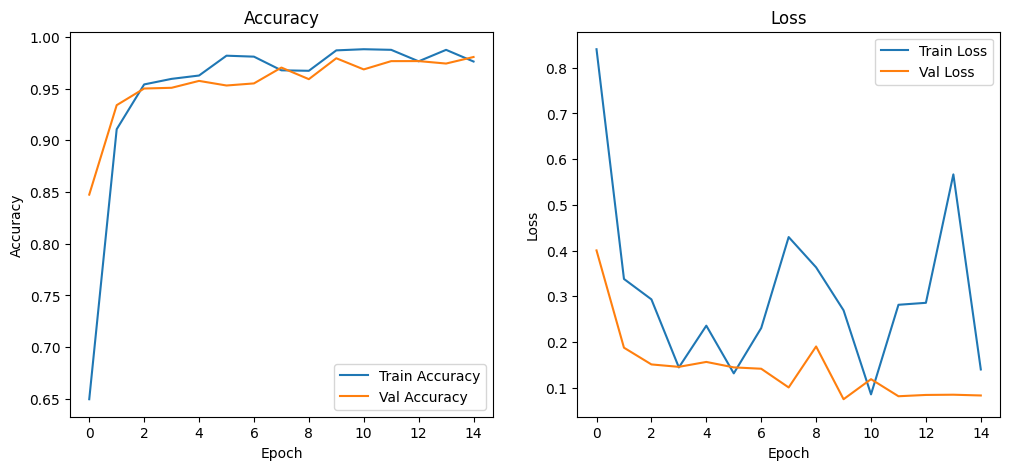

In [39]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import accuracy_score, f1_score

# Define the dimensions
height, width, channels = 16, 16, 2  # Example dimensions

# Define a robust 2D CNN model
def create_model():
    model = Sequential()
    # Add convolutional layers
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(height, width, channels)))
    model.add(MaxPooling2D(pool_size=(1, 1)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(1, 1)))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(1, 1)))
    # Flatten and add dense layers
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dense(len(np.unique(y_train)), activation='softmax'))  # Adjust output units based on number of classes
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Create the model
model = create_model()

# Define callbacks
checkpoint_cb = ModelCheckpoint('best_modelnewtask1.keras', save_best_only=True, monitor='val_loss', mode='min')
early_stopping_cb = EarlyStopping(monitor='val_loss', patience=5, mode='min', restore_best_weights=True)

# Train the model
history = model.fit(
    X_train, y_train,
    epochs=50,  # Adjust the number of epochs as needed
    batch_size=32,  # Adjust batch size as needed
    validation_data=(X_val, y_val),
    callbacks=[checkpoint_cb, early_stopping_cb]
)

# Load the best weights
model.load_weights('best_modelnewtask1.keras')

# Evaluate on validation set
y_val_pred = model.predict(X_val)
y_val_pred_classes = np.argmax(y_val_pred, axis=1)

accuracy = accuracy_score(y_val, y_val_pred_classes)
f1 = f1_score(y_val, y_val_pred_classes, average='weighted')

print(f"Validation Accuracy: {accuracy:.4f}")
print(f"Validation F1 Score: {f1:.4f}")

# Optionally, plot training history
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy')

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss')

plt.show()


In [4]:
# import numpy as np
# import tensorflow as tf
# from pathlib import Path
# from joblib import Parallel, delayed
# from sklearn.decomposition import PCA
# import pandas as pd

# # Define paths to the validation dataset
# dataset_paths = {
#     "R(2+1)D": Path("/kaggle/input/validation-iiith/r21d_val_features/R(2+1)D_val_features/frontal_view"),
#     "ResNet": Path("/kaggle/input/validation-iiith/ResNet_val_features/ResNet_val_features/frontal_view"),
#     "VGG16": Path("/kaggle/input/validation-iiith/VGG16_val_features/VGG16_val_features/frontal_view")
# }

# # Define maneuver classes for each backbone
# maneuver_classes_default = ["Left Lane Change", "Right Lane Change", "Left Turn", "Right Turn", "Slow-Stop", "Straight"]
# maneuver_classes_resnet = ["Left Lane Change", "Right Lane Change", "Left Turn", "Right Turn", "Stop", "Straight"]

# def load_vgg_r2_file(file_path):
#     try:
#         data = np.load(file_path, allow_pickle=True)
#         return data
#     except Exception as e:
#         print(f"Error loading {file_path}: {e}")
#         return None

# def load_resnet_file(file_path):
#     try:
#         data = np.load(file_path, allow_pickle=True).item()
#         if 'resnet' in data:
#             return data['resnet']
#         else:
#             raise ValueError("Key 'resnet' not found in the file")
#     except Exception as e:
#         print(f"Error loading {file_path}: {e}")
#         return None
    
# def process_folder(folder_path, class_index, is_resnet=False):
#     folder_path = Path(folder_path)
#     files = list(folder_path.glob('*.npy'))
    
#     features = []
#     video_names = []
#     missing_files = []

#     for file in files:
#         if is_resnet:
#             feature = load_resnet_file(file)
#         else:
#             feature = load_vgg_r2_file(file)
        
#         if feature is None:
#             missing_files.append(file.stem)
#             continue
#         if feature.ndim == 1:
#             feature = feature.reshape(1, -1)  # Handle 1D features
#         elif feature.ndim > 2:
#             feature = feature.reshape(feature.shape[0], -1)  # Flatten if needed
        
#         if feature.shape[0] == 0:
#             missing_files.append(file.stem)
#             continue
        
#         label = np.full((feature.shape[0], 1), class_index)
#         features.append(np.hstack((feature, label)))
#         video_names.append(file.stem)  # Track video names
    
#     if features:
#         return np.vstack(features), video_names, missing_files
#     return None, [], missing_files

# def load_dataset(dataset_paths, maneuver_classes, is_resnet=False):
#     all_features = []
#     video_names_all = []
#     missing_files_all = []

#     for backbone, path in dataset_paths.items():
#         if backbone == "ResNet" and not is_resnet:
#             continue
#         if backbone != "ResNet" and is_resnet:
#             continue
        
#         args = [(path / maneuver, maneuver_classes.index(maneuver), is_resnet) for maneuver in maneuver_classes if (path / maneuver).exists()]
        
#         results = Parallel(n_jobs=-1)(delayed(process_folder)(*arg) for arg in args)
        
#         backbone_features = [result[0] for result in results if result[0] is not None]
#         video_names = [result[1] for result in results if result[1] is not None]
#         missing_files = [result[2] for result in results if result[2] is not None]
        
#         if backbone_features:
#             features = np.vstack(backbone_features)
#             video_names_all.extend([name for sublist in video_names for name in sublist])
#             missing_files_all.extend([name for sublist in missing_files for name in sublist])
#             all_features.append(features[:, :-1])  # Exclude the last column (label)
    
#     if all_features:
#         X_combined = np.vstack(all_features)
#     else:
#         raise ValueError("No features available to combine")
    
#     return X_combined, video_names_all, missing_files_all

# # Load the datasets for each backbone
# X_r21d, video_names_r21d, missing_r21d = load_dataset(dataset_paths, maneuver_classes_default, is_resnet=False)
# X_vgg16, video_names_vgg16, missing_vgg16 = load_dataset(dataset_paths, maneuver_classes_default, is_resnet=False)
# X_resnet, video_names_resnet, missing_resnet = load_dataset(dataset_paths, maneuver_classes_resnet, is_resnet=True)

# # Normalize features
# X_r21d = X_r21d.astype(np.float32) / 255
# X_vgg16 = X_vgg16.astype(np.float32) / 255
# X_resnet = X_resnet.astype(np.float32) / 255

# print(f"R(2+1)D video count: {len(video_names_r21d)}")
# print(f"VGG16 video count: {len(video_names_vgg16)}")
# print(f"ResNet video count: {len(video_names_resnet)}")
# print(f"Missing ResNet videos: {len(missing_resnet)}")
# print(f"Missing ResNet video names: {missing_resnet}")

# # Apply PCA to ResNet features
# common_dim = 512
# pca_resnet = PCA(n_components=common_dim)
# X_resnet_pca = pca_resnet.fit_transform(X_resnet)

# # Reshape the data to match the model's expected input shape
# X_r21d_reshaped = X_r21d.reshape(-1, 16, 16, 2)
# X_vgg16_reshaped = X_vgg16.reshape(-1, 16, 16, 2)
# X_resnet_reshaped = X_resnet_pca.reshape(-1, 16, 16, 2)

# # Load the saved model (updated path)
# model_path = '/kaggle/input/testdataripiiith/best_modelnewtask1.keras'
# model = tf.keras.models.load_model(model_path)

# # Predict using the model
# def predict_and_average(X, video_names):
#     predictions = model.predict(X)
#     binary_predictions = np.zeros_like(predictions)
#     max_indices = np.argmax(predictions, axis=1)
#     for i, idx in enumerate(max_indices):
#         binary_predictions[i, idx] = 1

#     predictions_dict = dict(zip(video_names, binary_predictions))

#     averaged_predictions = {}
#     for video_name, pred in predictions_dict.items():
#         if video_name in averaged_predictions:
#             averaged_predictions[video_name].append(pred)
#         else:
#             averaged_predictions[video_name] = [pred]
    
#     # Compute average predictions
#     final_predictions = {}
#     for video_name, preds in averaged_predictions.items():
#         avg_pred = np.mean(np.array(preds), axis=0)
#         final_predictions[video_name] = avg_pred
    
#     return final_predictions

# # Predict and average results for each backbone
# averaged_predictions_r21d = predict_and_average(X_r21d_reshaped, video_names_r21d)
# averaged_predictions_vgg16 = predict_and_average(X_vgg16_reshaped, video_names_vgg16)
# averaged_predictions_resnet = predict_and_average(X_resnet_reshaped, video_names_resnet)

# # Print the count of predictions for each backbone
# print(f"R(2+1)D prediction count: {len(averaged_predictions_r21d)}")
# print(f"VGG16 prediction count: {len(averaged_predictions_vgg16)}")
# print(f"ResNet prediction count: {len(averaged_predictions_resnet)}")

# # Convert final predictions to DataFrame
# df_r21d = pd.DataFrame(averaged_predictions_r21d.values(), columns=maneuver_classes_default, index=averaged_predictions_r21d.keys())
# df_r21d.insert(0, 'video_name', df_r21d.index)
# df_r21d.insert(1, 'backbone', 'R(2+1)D')

# df_vgg16 = pd.DataFrame(averaged_predictions_vgg16.values(), columns=maneuver_classes_default, index=averaged_predictions_vgg16.keys())
# df_vgg16.insert(0, 'video_name', df_vgg16.index)
# df_vgg16.insert(1, 'backbone', 'VGG16')

# df_resnet = pd.DataFrame(averaged_predictions_resnet.values(), columns=maneuver_classes_resnet, index=averaged_predictions_resnet.keys())
# df_resnet.insert(0, 'video_name', df_resnet.index)
# df_resnet.insert(1, 'backbone', 'ResNet')

# # Replace "Slow-Stop" column values for ResNet predictions with "Stop" values
# df_resnet['Slow-Stop'] = df_resnet['Stop']
# df_resnet = df_resnet.drop(columns=['Stop'])

# # Combine results into a single DataFrame
# df_results = pd.concat([df_r21d, df_vgg16, df_resnet], ignore_index=True)

# # Ensure the correct order of columns
# df_results = df_results[['video_name', 'backbone'] + maneuver_classes_default]

# # Save the results to a CSV file
# output_csv_path = 'validation_predictions.csv'
# df_results.to_csv(output_csv_path, index=False)
# print(f"Predictions saved to {output_csv_path}")


test set task 1

In [2]:
# import numpy as np

# # Define file paths
# file_paths = {
#     "R(2+1)D": "/kaggle/input/testdataripiiith/R(21)D_test_features/R(2+1)D_test_features/frontal_view/004ed8d4-5be9-4963-bdb3-8aace317cd74.npy",
#     "VGG16": "/kaggle/input/testdataripiiith/VGG16_test_features/VGG16_test_features/frontal_view/VGG16_features/004ed8d4-5be9-4963-bdb3-8aace317cd74.npy",
#     "ResNet": "/kaggle/input/testdataripiiith/ResNet_test_features/ResNet_test_features/frontal_view/004ed8d4-5be9-4963-bdb3-8aace317cd74.npy"
# }

# def inspect_npy_file(file_path):
#     try:
#         data = np.load(file_path, allow_pickle=True)
#         print(f"File: {file_path}")
#         print(f"Shape: {data.shape}")
#         print(f"Data type: {data.dtype}")
#         print(f"First element: {data[0] if data.size > 0 else 'Empty'}")
#         return data
#     except Exception as e:
#         print(f"Error loading {file_path}: {e}")
#         return None

# # Inspect each file
# for label, path in file_paths.items():
#     inspect_npy_file(path)


In [3]:
# import numpy as np
# import tensorflow as tf
# from pathlib import Path
# from joblib import Parallel, delayed
# from sklearn.decomposition import PCA
# import pandas as pd

# # Define paths to the validation dataset
# dataset_paths = {
#     "R(2+1)D": Path("/kaggle/input/testdataripiiith/R(21)D_test_features/R(2+1)D_test_features/frontal_view"),
#     "ResNet": Path("/kaggle/input/testdataripiiith/ResNet_test_features/ResNet_test_features/frontal_view"),
#     "VGG16": Path("/kaggle/input/testdataripiiith/VGG16_test_features/VGG16_test_features/frontal_view/VGG16_features")
# }

# def load_vgg_r2_file(file_path):
#     try:
#         data = np.load(file_path, allow_pickle=True)
#         return data
#     except Exception as e:
#         print(f"Error loading {file_path}: {e}")
#         return None

# def load_resnet_file(file_path):
#     try:
#         data = np.load(file_path, allow_pickle=True).item()
#         if 'resnet' in data:
#             return data['resnet']
#         else:
#             raise ValueError("Key 'resnet' not found in the file")
#     except Exception as e:
#         print(f"Error loading {file_path}: {e}")
#         return None

# def process_folder(folder_path, is_resnet=False):
#     folder_path = Path(folder_path)
#     files = list(folder_path.glob('*.npy'))
    
#     features = []
#     video_names = []
#     missing_files = []

#     print(f"Processing folder: {folder_path}")

#     for file in files:
#         print(f"Processing file: {file}")
#         if is_resnet:
#             feature = load_resnet_file(file)
#         else:
#             feature = load_vgg_r2_file(file)
        
#         if feature is None:
#             missing_files.append(file.stem)
#             continue
        
#         # Check dimensions before processing
#         if feature.ndim == 1:
#             feature = feature.reshape(1, -1)
#         elif feature.ndim > 2:
#             feature = feature.reshape(feature.shape[0], -1)
        
#         if feature.shape[0] == 0 or feature.shape[1] == 0:
#             missing_files.append(file.stem)
#             continue
        
#         features.append(feature)
#         video_names.append(file.stem)
    
#     if features:
#         return np.vstack(features), video_names, missing_files
#     return None, [], missing_files

# def load_dataset(dataset_paths, is_resnet=False):
#     all_features = []
#     video_names_all = []
#     missing_files_all = []

#     for backbone, path in dataset_paths.items():
#         if backbone == "ResNet" and not is_resnet:
#             continue
#         if backbone != "ResNet" and is_resnet:
#             continue
        
#         print(f"Loading dataset for {backbone}")
#         results = Parallel(n_jobs=-1)(delayed(process_folder)(path, is_resnet) for path in [path])
        
#         backbone_features = [result[0] for result in results if result[0] is not None]
#         video_names = [result[1] for result in results if result[1] is not None]
#         missing_files = [result[2] for result in results if result[2] is not None]

#         if backbone_features:
#             # Filter out empty features
#             backbone_features = [f for f in backbone_features if f.size > 0]
#             if backbone_features:
#                 features = np.vstack(backbone_features)
#                 video_names_all.extend([name for sublist in video_names for name in sublist])
#                 missing_files_all.extend([name for sublist in missing_files for name in sublist])
#                 all_features.append(features)
#             else:
#                 print(f"No valid features found for {backbone}")
#         else:
#             print(f"No features found for {backbone}")

#     if all_features:
#         X_combined = np.vstack(all_features)
#     else:
#         raise ValueError("No features available to combine")
    
#     return X_combined, video_names_all, missing_files_all

# # Load the datasets for each backbone
# X_r21d, video_names_r21d, missing_r21d = load_dataset(dataset_paths, is_resnet=False)
# X_vgg16, video_names_vgg16, missing_vgg16 = load_dataset(dataset_paths, is_resnet=False)
# X_resnet, video_names_resnet, missing_resnet = load_dataset(dataset_paths, is_resnet=True)

# # Check if feature arrays are empty
# if X_r21d.size == 0:
#     raise ValueError("R(2+1)D features are empty")
# if X_vgg16.size == 0:
#     raise ValueError("VGG16 features are empty")
# if X_resnet.size == 0:
#     raise ValueError("ResNet features are empty")

# # Normalize features
# X_r21d = X_r21d.astype(np.float32) / 255
# X_vgg16 = X_vgg16.astype(np.float32) / 255
# X_resnet = X_resnet.astype(np.float32) / 255

# print(f"R(2+1)D video count: {len(video_names_r21d)}")
# print(f"VGG16 video count: {len(video_names_vgg16)}")
# print(f"ResNet video count: {len(video_names_resnet)}")
# print(f"Missing ResNet videos: {len(missing_resnet)}")
# print(f"Missing ResNet video names: {missing_resnet}")

# # Apply PCA to ResNet features
# common_dim = 512
# pca_resnet = PCA(n_components=common_dim)
# X_resnet_pca = pca_resnet.fit_transform(X_resnet)

# # Reshape the data to match the model's expected input shape
# X_r21d_reshaped = X_r21d.reshape(-1, 16, 16, 2)
# X_vgg16_reshaped = X_vgg16.reshape(-1, 16, 16, 2)
# X_resnet_reshaped = X_resnet_pca.reshape(-1, 16, 16, 2)

# # Load the saved model (updated path)
# model_path = '/kaggle/input/testdataripiiith/best_modelnewtask1.keras'
# model = tf.keras.models.load_model(model_path)

# # Predict using the model
# def predict_and_average(X, video_names):
#     predictions = model.predict(X)
#     binary_predictions = np.zeros_like(predictions)
#     max_indices = np.argmax(predictions, axis=1)
#     for i, idx in enumerate(max_indices):
#         binary_predictions[i, idx] = 1

#     predictions_dict = dict(zip(video_names, binary_predictions))

#     averaged_predictions = {}
#     for video_name, pred in predictions_dict.items():
#         if video_name in averaged_predictions:
#             averaged_predictions[video_name].append(pred)
#         else:
#             averaged_predictions[video_name] = [pred]
    
#     # Compute average predictions
#     final_predictions = {}
#     for video_name, preds in averaged_predictions.items():
#         avg_pred = np.mean(np.array(preds), axis=0)
#         final_predictions[video_name] = avg_pred
    
#     return final_predictions

# # Predict and average results for each backbone
# averaged_predictions_r21d = predict_and_average(X_r21d_reshaped, video_names_r21d)
# averaged_predictions_vgg16 = predict_and_average(X_vgg16_reshaped, video_names_vgg16)
# averaged_predictions_resnet = predict_and_average(X_resnet_reshaped, video_names_resnet)

# # Print the count of predictions for each backbone
# print(f"R(2+1)D prediction count: {len(averaged_predictions_r21d)}")
# print(f"VGG16 prediction count: {len(averaged_predictions_vgg16)}")
# print(f"ResNet prediction count: {len(averaged_predictions_resnet)}")

# # Convert final predictions to DataFrame
# df_r21d = pd.DataFrame(averaged_predictions_r21d.values(), columns=[f'Class_{i}' for i in range(averaged_predictions_r21d[list(averaged_predictions_r21d.keys())[0]].size)], index=averaged_predictions_r21d.keys())
# df_r21d.insert(0, 'video_name', df_r21d.index)
# df_r21d.insert(1, 'backbone', 'R(2+1)D')

# df_vgg16 = pd.DataFrame(averaged_predictions_vgg16.values(), columns=[f'Class_{i}' for i in range(averaged_predictions_vgg16[list(averaged_predictions_vgg16.keys())[0]].size)], index=averaged_predictions_vgg16.keys())
# df_vgg16.insert(0, 'video_name', df_vgg16.index)
# df_vgg16.insert(1, 'backbone', 'VGG16')

# df_resnet = pd.DataFrame(averaged_predictions_resnet.values(), columns=[f'Class_{i}' for i in range(averaged_predictions_resnet[list(averaged_predictions_resnet.keys())[0]].size)], index=averaged_predictions_resnet.keys())
# df_resnet.insert(0, 'video_name', df_resnet.index)
# df_resnet.insert(1, 'backbone', 'ResNet')

# # Combine DataFrames
# df_final = pd.concat([df_r21d, df_vgg16, df_resnet])
# df_final.to_csv('/kaggle/working/final_predictions.csv', index=False)

# print("Final predictions saved to final_predictions.csv")


task 2

In [1]:
import numpy as np
from pathlib import Path
from joblib import Parallel, delayed
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA

# Define paths to the dataset
dataset_paths = {
    "R(2+1)D": {
        "frontal_view": Path("/kaggle/input/iiit-hyderabad-datasets-manoevures/r21d_training_features/R(2+1)D_Training_Features/frontal_view"),
        "left_side_mirror_view": Path("/kaggle/input/iiit-hyderabad-datasets-manoevures/r21d_training_features/R(2+1)D_Training_Features/left_side_mirror_view"),
        "right_side_mirror_view": Path("/kaggle/input/iiit-hyderabad-datasets-manoevures/r21d_training_features/R(2+1)D_Training_Features/right_side_mirror_view")
    },
    "ResNet": {
        "frontal_view": Path("/kaggle/input/iiit-hyderabad-datasets-manoevures/resnet_training_features/ResNet_Training_Features/frontal_view"),
        "left_side_mirror_view": Path("/kaggle/input/iiit-hyderabad-datasets-manoevures/resnet_training_features/ResNet_Training_Features/left_side_mirror_view"),
        "right_side_mirror_view": Path("/kaggle/input/iiit-hyderabad-datasets-manoevures/resnet_training_features/ResNet_Training_Features/right_side_mirror_view")
    },
    "VGG16": {
        "frontal_view": Path("/kaggle/input/iiit-hyderabad-datasets-manoevures/vgg16_training_features/VGG16_Training_Features/frontal_view"),
        "left_side_mirror_view": Path("/kaggle/input/iiit-hyderabad-datasets-manoevures/vgg16_training_features/VGG16_Training_Features/left_side_mirror_view"),
        "right_side_mirror_view": Path("/kaggle/input/iiit-hyderabad-datasets-manoevures/vgg16_training_features/VGG16_Training_Features/right_side_mirror_view")
    }
}

maneuver_classes = ["Left Lane Change", "Right Lane Change", "Left Turn", "Right Turn", "Slow-Stop", "Straight"]

def load_vgg_r2_file(file_path):
    try:
        data = np.load(file_path, allow_pickle=True)
        return data
    except Exception as e:
        print(f"Error loading {file_path}: {e}")
        return None

def load_resnet_file(file_path):
    try:
        data = np.load(file_path, allow_pickle=True).item()
        if 'resnet' in data:
            return data['resnet']
        else:
            raise ValueError("Key 'resnet' not found in the file")
    except Exception as e:
        print(f"Error loading {file_path}: {e}")
        return None

def process_folder(folder_path, class_index, is_resnet=False):
    folder_path = Path(folder_path)
    files = list(folder_path.glob('*.npy'))
    
    features = []
    for file in files:
        if is_resnet:
            feature = load_resnet_file(file)
        else:
            feature = load_vgg_r2_file(file)
        
        if feature is None:
            continue
        if feature.ndim == 1:
            feature = feature.reshape(1, -1)  # Handle 1D features
        elif feature.ndim > 2:
            feature = feature.reshape(feature.shape[0], -1)  # Flatten if needed
        
        if feature.shape[0] == 0:
            continue
        
        label = np.full((feature.shape[0], 1), class_index)
        features.append(np.hstack((feature, label)))
    
    if features:
        return np.vstack(features)
    return None

def load_dataset(dataset_paths, maneuver_classes, is_resnet=False):
    all_features = []
    all_labels = []
    
    for backbone, views in dataset_paths.items():
        if backbone == "ResNet" and not is_resnet:
            continue
        if backbone != "ResNet" and is_resnet:
            continue
        
        for view, path in views.items():
            args = [(path / maneuver, maneuver_classes.index(maneuver), is_resnet) for maneuver in maneuver_classes if (path / maneuver).exists()]
            
            results = Parallel(n_jobs=-1)(delayed(process_folder)(*arg) for arg in args)
            
            backbone_features = [result for result in results if result is not None]
            
            if backbone_features:
                features = np.vstack(backbone_features)
                all_features.append(features[:, :-1])  # Exclude the last column (label)
                all_labels.append(features[:, -1])     # Last column is the label
    
    if all_features:
        X_combined = np.vstack(all_features)
        y_combined = np.concatenate(all_labels)
    else:
        raise ValueError("No features available to combine")
    
    return X_combined, y_combined

# Load the datasets
X_resnet, y_resnet = load_dataset(dataset_paths, maneuver_classes, is_resnet=True)
X_vgg_r2, y_vgg_r2 = load_dataset(dataset_paths, maneuver_classes, is_resnet=False)

# Project features to common dimensionality
common_dim = 512

# Apply PCA to ResNet features
pca_resnet = PCA(n_components=common_dim)
X_resnet_pca = pca_resnet.fit_transform(X_resnet)

# Check PCA output
print(f"PCA ResNet features shape: {X_resnet_pca.shape}")

# Combine features and labels
X_combined = np.vstack([X_resnet_pca, X_vgg_r2])
y_combined = np.concatenate([y_resnet, y_vgg_r2])

# Encode the labels if necessary
le = LabelEncoder()
y_encoded = le.fit_transform(y_combined)

# Check final shapes
print(f"Combined features shape: {X_combined.shape}")
print(f"Combined labels shape: {y_combined.shape}")
print(f"Encoded labels shape: {y_encoded.shape}")


PCA ResNet features shape: (338436, 512)
Combined features shape: (690306, 512)
Combined labels shape: (690306,)
Encoded labels shape: (690306,)


In [3]:
from sklearn.model_selection import train_test_split

# New dimensions
height, width, channels = 16, 16, 2  # Example dimensions, should match the total number of features

# Ensure the total number of elements matches
if X_combined.shape[1] != height * width * channels:
    raise ValueError(f"Feature dimensions mismatch: expected {height * width * channels}, got {X_combined.shape[1]}")

# Reshape features to (num_samples, height, width, channels)
X_reshaped = X_combined.reshape((-1, height, width, channels))

# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_reshaped, y_encoded, test_size=0.2, random_state=42)

# Optional: Normalize pixel values to the range [0, 1]
X_train = X_train.astype('float32') / 255.0
X_val = X_val.astype('float32') / 255.0

# Example to check the shapes of training and validation sets
print(f"Training features shape: {X_train.shape}")
print(f"Training labels shape: {y_train.shape}")
print(f"Validation features shape: {X_val.shape}")
print(f"Validation labels shape: {y_val.shape}")

Training features shape: (552244, 16, 16, 2)
Training labels shape: (552244,)
Validation features shape: (138062, 16, 16, 2)
Validation labels shape: (138062,)


2024-07-21 16:43:56.147102: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-21 16:43:56.147248: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-21 16:43:56.292104: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
   47/17258 ━━━━━━━━━━━━━━━━━━━━ 56s 3ms/step - accuracy: 0.2579 - loss: 1.6751 

I0000 00:00:1721580255.117430     131 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


17258/17258 ━━━━━━━━━━━━━━━━━━━━ 74s 4ms/step - accuracy: 0.6858 - loss: 0.7504 - val_accuracy: 0.9747 - val_loss: 0.0768
Epoch 2/50
17258/17258 ━━━━━━━━━━━━━━━━━━━━ 62s 4ms/step - accuracy: 0.9795 - loss: 0.0598 - val_accuracy: 0.9773 - val_loss: 0.0740
Epoch 3/50
17258/17258 ━━━━━━━━━━━━━━━━━━━━ 63s 4ms/step - accuracy: 0.9846 - loss: 0.0493 - val_accuracy: 0.9888 - val_loss: 0.0404
Epoch 4/50
17258/17258 ━━━━━━━━━━━━━━━━━━━━ 62s 4ms/step - accuracy: 0.9885 - loss: 0.0381 - val_accuracy: 0.9701 - val_loss: 0.1417
Epoch 5/50
17258/17258 ━━━━━━━━━━━━━━━━━━━━ 62s 4ms/step - accuracy: 0.9901 - loss: 0.0339 - val_accuracy: 0.9934 - val_loss: 0.0414
Epoch 6/50
17258/17258 ━━━━━━━━━━━━━━━━━━━━ 62s 4ms/step - accuracy: 0.9941 - loss: 0.0215 - val_accuracy: 0.9926 - val_loss: 0.0459
Epoch 7/50
17258/17258 ━━━━━━━━━━━━━━━━━━━━ 62s 4ms/step - accuracy: 0.9940 - loss: 0.0236 - val_accuracy: 0.9951 - val_loss: 0.0338
Epoch 8/50
17258/17258 ━━━━━━━━━━━━━━━━━━━━ 62s 4ms/step - accuracy: 0.9911 - lo

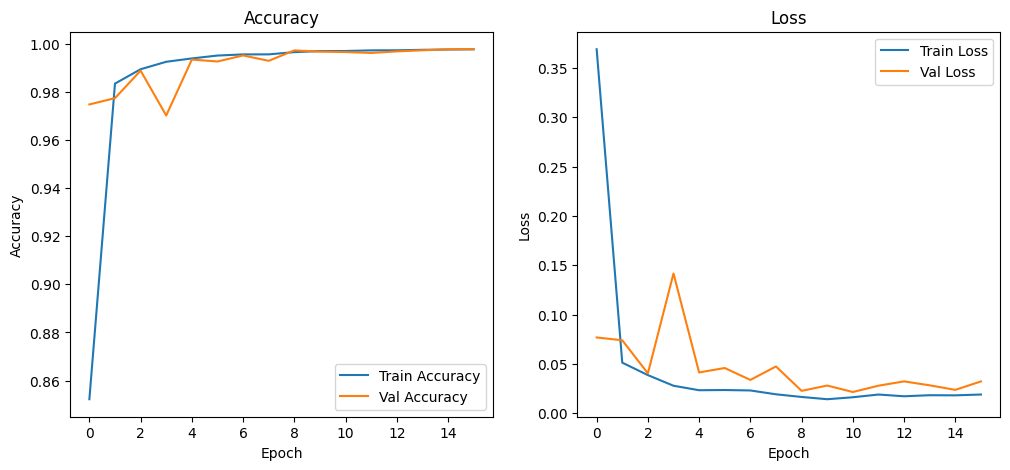

In [4]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import accuracy_score, f1_score

# Define the dimensions
height, width, channels = 16, 16, 2  # Example dimensions

# Define a robust 2D CNN model
def create_model():
    model = Sequential()
    # Add convolutional layers
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(height, width, channels)))
    model.add(MaxPooling2D(pool_size=(1, 1)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(1, 1)))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(1, 1)))
    # Flatten and add dense layers
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dense(len(np.unique(y_train)), activation='softmax'))  # Adjust output units based on number of classes
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Create the model
model = create_model()

# Define callbacks
checkpoint_cb = ModelCheckpoint('best_modelnewtask2.keras', save_best_only=True, monitor='val_loss', mode='min')
early_stopping_cb = EarlyStopping(monitor='val_loss', patience=5, mode='min', restore_best_weights=True)

# Train the model
history = model.fit(
    X_train, y_train,
    epochs=50,  # Adjust the number of epochs as needed
    batch_size=32,  # Adjust batch size as needed
    validation_data=(X_val, y_val),
    callbacks=[checkpoint_cb, early_stopping_cb]
)

# Load the best weights
model.load_weights('best_modelnewtask2.keras')

# Evaluate on validation set
y_val_pred = model.predict(X_val)
y_val_pred_classes = np.argmax(y_val_pred, axis=1)

accuracy = accuracy_score(y_val, y_val_pred_classes)
f1 = f1_score(y_val, y_val_pred_classes, average='weighted')

print(f"Validation Accuracy: {accuracy:.4f}")
print(f"Validation F1 Score: {f1:.4f}")

# Optionally, plot training history
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy')

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss')

plt.show()


In [1]:
# import numpy as np
# import tensorflow as tf
# from pathlib import Path
# from joblib import Parallel, delayed
# from sklearn.decomposition import PCA
# import pandas as pd

# # Define paths to the validation dataset
# dataset_paths = {
#     "R(2+1)D_frontal": Path("/kaggle/input/validation-iiith/r21d_val_features/R(2+1)D_val_features/frontal_view"),
#     "R(2+1)D_left": Path("/kaggle/input/validation-iiith/r21d_val_features/R(2+1)D_val_features/left_side_mirror_view"),
#     "R(2+1)D_right": Path("/kaggle/input/validation-iiith/r21d_val_features/R(2+1)D_val_features/right_side_mirror_view"),
#     "ResNet_frontal": Path("/kaggle/input/validation-iiith/ResNet_val_features/ResNet_val_features/frontal_view"),
#     "ResNet_left": Path("/kaggle/input/validation-iiith/ResNet_val_features/ResNet_val_features/left_side_mirror_view"),
#     "ResNet_right": Path("/kaggle/input/validation-iiith/ResNet_val_features/ResNet_val_features/right_side_mirror_view"),
#     "VGG16_frontal": Path("/kaggle/input/validation-iiith/VGG16_val_features/VGG16_val_features/frontal_view"),
#     "VGG16_left": Path("/kaggle/input/validation-iiith/VGG16_val_features/VGG16_val_features/left_side_mirror_view"),
#     "VGG16_right": Path("/kaggle/input/validation-iiith/VGG16_val_features/VGG16_val_features/right_side_mirror_view")
# }

# maneuver_classes = ["Left Lane Change", "Right Lane Change", "Left Turn", "Right Turn", "Slow-Stop", "Straight"]
# maneuver_classes_resnet = ["Left Lane Change", "Right Lane Change", "Left Turn", "Right Turn", "Stop", "Straight"]

# def load_vgg_r2_file(file_path):
#     try:
#         data = np.load(file_path, allow_pickle=True)
#         return data
#     except Exception as e:
#         print(f"Error loading {file_path}: {e}")
#         return None

# def load_resnet_file(file_path):
#     try:
#         data = np.load(file_path, allow_pickle=True).item()
#         if 'resnet' in data:
#             return data['resnet']
#         else:
#             raise ValueError("Key 'resnet' not found in the file")
#     except Exception as e:
#         print(f"Error loading {file_path}: {e}")
#         return None

# def process_folder(folder_path, class_index, is_resnet=False):
#     folder_path = Path(folder_path)
#     files = list(folder_path.glob('*.npy'))
    
#     features = []
#     video_names = []
#     missing_files = []

#     for file in files:
#         if is_resnet:
#             feature = load_resnet_file(file)
#         else:
#             feature = load_vgg_r2_file(file)
        
#         if feature is None:
#             missing_files.append(file.stem)
#             continue
#         if feature.ndim == 1:
#             feature = feature.reshape(1, -1)  # Handle 1D features
#         elif feature.ndim > 2:
#             feature = feature.reshape(feature.shape[0], -1)  # Flatten if needed
        
#         if feature.shape[0] == 0:
#             missing_files.append(file.stem)
#             continue
        
#         label = np.full((feature.shape[0], 1), class_index)
#         features.append(np.hstack((feature, label)))
#         video_names.append(file.stem)  # Track video names
    
#     if features:
#         return np.vstack(features), video_names, missing_files
#     return None, [], missing_files

# def load_dataset(dataset_paths, maneuver_classes, is_resnet=False):
#     all_features = []
#     video_names_all = []
#     missing_files_all = []

#     for path_label, path in dataset_paths.items():
#         is_resnet_path = "ResNet" in path_label
#         if is_resnet_path != is_resnet:
#             continue
        
#         args = [(path / maneuver, maneuver_classes.index(maneuver), is_resnet_path) for maneuver in (maneuver_classes_resnet if is_resnet else maneuver_classes) if (path / maneuver).exists()]
        
#         results = Parallel(n_jobs=-1)(delayed(process_folder)(*arg) for arg in args)
        
#         backbone_features = [result[0] for result in results if result[0] is not None]
#         video_names = [result[1] for result in results if result[1] is not None]
#         missing_files = [result[2] for result in results if result[2] is not None]
        
#         if backbone_features:
#             features = np.vstack(backbone_features)
#             video_names_all.extend([name for sublist in video_names for name in sublist])
#             missing_files_all.extend([name for sublist in missing_files for name in sublist])
#             all_features.append(features[:, :-1])  # Exclude the last column (label)
    
#     if all_features:
#         X_combined = np.vstack(all_features)
#     else:
#         raise ValueError("No features available to combine")
    
#     return X_combined, video_names_all, missing_files_all

# # Load the datasets for each backbone and view
# X_r21d, video_names_r21d, missing_r21d = load_dataset(dataset_paths, maneuver_classes, is_resnet=False)
# X_vgg16, video_names_vgg16, missing_vgg16 = load_dataset(dataset_paths, maneuver_classes, is_resnet=False)
# X_resnet, video_names_resnet, missing_resnet = load_dataset(dataset_paths, maneuver_classes_resnet, is_resnet=True)

# print(f"R(2+1)D video count: {len(video_names_r21d)}")
# print(f"VGG16 video count: {len(video_names_vgg16)}")
# print(f"ResNet video count: {len(video_names_resnet)}")
# print(f"Missing ResNet videos: {len(missing_resnet)}")
# print(f"Missing ResNet video names: {missing_resnet}")

# # Apply PCA to ResNet features
# common_dim = 512
# pca_resnet = PCA(n_components=common_dim)
# X_resnet_pca = pca_resnet.fit_transform(X_resnet)

# # Normalize and reshape the data to match the model's expected input shape
# X_r21d_normalized = X_r21d.astype(np.float32) / 255
# X_vgg16_normalized = X_vgg16.astype(np.float32) / 255
# X_resnet_pca_normalized = X_resnet_pca.astype(np.float32) / 255

# X_r21d_reshaped = X_r21d_normalized.reshape(-1, 16, 16, 2)
# X_vgg16_reshaped = X_vgg16_normalized.reshape(-1, 16, 16, 2)
# X_resnet_reshaped = X_resnet_pca_normalized.reshape(-1, 16, 16, 2)

# # Load the saved model
# model_path = '/kaggle/input/testdataripiiith/best_modelnewtask2 (1).keras'
# model = tf.keras.models.load_model(model_path)

# # Predict using the model
# def predict_and_average(X, video_names):
#     predictions = model.predict(X)
#     binary_predictions = np.zeros_like(predictions)
#     max_indices = np.argmax(predictions, axis=1)
#     for i, idx in enumerate(max_indices):
#         binary_predictions[i, idx] = 1

#     predictions_dict = dict(zip(video_names, binary_predictions))

#     averaged_predictions = {}
#     for video_name, pred in predictions_dict.items():
#         if video_name in averaged_predictions:
#             averaged_predictions[video_name].append(pred)
#         else:
#             averaged_predictions[video_name] = [pred]
    
#     # Compute average predictions
#     final_predictions = {}
#     for video_name, preds in averaged_predictions.items():
#         avg_pred = np.mean(np.array(preds), axis=0)
#         final_predictions[video_name] = avg_pred
    
#     return final_predictions

# # Predict and average results for each backbone and view
# averaged_predictions_r21d = predict_and_average(X_r21d_reshaped, video_names_r21d)
# averaged_predictions_vgg16 = predict_and_average(X_vgg16_reshaped, video_names_vgg16)
# averaged_predictions_resnet = predict_and_average(X_resnet_reshaped, video_names_resnet)

# # Convert final predictions to DataFrame
# def create_dataframe(predictions, backbone_view_label):
#     df = pd.DataFrame(predictions.values(), columns=maneuver_classes_resnet if 'ResNet' in backbone_view_label else maneuver_classes, index=predictions.keys())
#     df.insert(0, 'video_name', df.index)
#     df.insert(1, 'backbone_view', backbone_view_label)
#     return df

# df_r21d_frontal = create_dataframe(averaged_predictions_r21d, 'R(2+1)D_frontal')
# df_vgg16_frontal = create_dataframe(averaged_predictions_vgg16, 'VGG16_frontal')
# df_resnet_frontal = create_dataframe(averaged_predictions_resnet, 'ResNet_frontal')

# # Process other views
# X_r21d_left, video_names_r21d_left, _ = load_dataset({k: v for k, v in dataset_paths.items() if 'left' in k}, maneuver_classes, is_resnet=False)
# X_vgg16_left, video_names_vgg16_left, _ = load_dataset({k: v for k, v in dataset_paths.items() if 'left' in k}, maneuver_classes, is_resnet=False)
# X_resnet_left, video_names_resnet_left, _ = load_dataset({k: v for k, v in dataset_paths.items() if 'left' in k}, maneuver_classes_resnet, is_resnet=True)

# X_r21d_right, video_names_r21d_right, _ = load_dataset({k: v for k, v in dataset_paths.items() if 'right' in k}, maneuver_classes, is_resnet=False)
# X_vgg16_right, video_names_vgg16_right, _ = load_dataset({k: v for k, v in dataset_paths.items() if 'right' in k}, maneuver_classes, is_resnet=False)
# X_resnet_right, video_names_resnet_right, _ = load_dataset({k: v for k, v in dataset_paths.items() if 'right' in k}, maneuver_classes_resnet, is_resnet=True)

# # Normalize and reshape
# X_r21d_left_normalized = X_r21d_left.astype(np.float32) / 255
# X_vgg16_left_normalized = X_vgg16_left.astype(np.float32) / 255
# X_resnet_left_pca_normalized = pca_resnet.transform(X_resnet_left).astype(np.float32) / 255

# X_r21d_right_normalized = X_r21d_right.astype(np.float32) / 255
# X_vgg16_right_normalized = X_vgg16_right.astype(np.float32) / 255
# X_resnet_right_pca_normalized = pca_resnet.transform(X_resnet_right).astype(np.float32) / 255

# X_r21d_left_reshaped = X_r21d_left_normalized.reshape(-1, 16, 16, 2)
# X_vgg16_left_reshaped = X_vgg16_left_normalized.reshape(-1, 16, 16, 2)
# X_resnet_left_reshaped = X_resnet_left_pca_normalized.reshape(-1, 16, 16, 2)

# X_r21d_right_reshaped = X_r21d_right_normalized.reshape(-1, 16, 16, 2)
# X_vgg16_right_reshaped = X_vgg16_right_normalized.reshape(-1, 16, 16, 2)
# X_resnet_right_reshaped = X_resnet_right_pca_normalized.reshape(-1, 16, 16, 2)

# # Predict and average results for left and right views
# averaged_predictions_r21d_left = predict_and_average(X_r21d_left_reshaped, video_names_r21d_left)
# averaged_predictions_vgg16_left = predict_and_average(X_vgg16_left_reshaped, video_names_vgg16_left)
# averaged_predictions_resnet_left = predict_and_average(X_resnet_left_reshaped, video_names_resnet_left)

# averaged_predictions_r21d_right = predict_and_average(X_r21d_right_reshaped, video_names_r21d_right)
# averaged_predictions_vgg16_right = predict_and_average(X_vgg16_right_reshaped, video_names_vgg16_right)
# averaged_predictions_resnet_right = predict_and_average(X_resnet_right_reshaped, video_names_resnet_right)

# # Convert final predictions to DataFrame
# df_r21d_left = create_dataframe(averaged_predictions_r21d_left, 'R(2+1)D_left')
# df_vgg16_left = create_dataframe(averaged_predictions_vgg16_left, 'VGG16_left')
# df_resnet_left = create_dataframe(averaged_predictions_resnet_left, 'ResNet_left')

# df_r21d_right = create_dataframe(averaged_predictions_r21d_right, 'R(2+1)D_right')
# df_vgg16_right = create_dataframe(averaged_predictions_vgg16_right, 'VGG16_right')
# df_resnet_right = create_dataframe(averaged_predictions_resnet_right, 'ResNet_right')

# # Combine all results into a single DataFrame
# df_final = pd.concat([df_r21d_frontal, df_vgg16_frontal, df_resnet_frontal,
#                       df_r21d_left, df_vgg16_left, df_resnet_left,
#                       df_r21d_right, df_vgg16_right, df_resnet_right], ignore_index=True)

# # Save the final predictions to CSV
# df_final.to_csv('final_predictions.csv', index=False)
